<center>

*******************************************************************************************

### GENERATE SYNTHETIC DATA
##### TO TEST THE MEASUREMENT OF SYNCHRONISATION

##### 21 March 2025

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* In this context, synchrony is defined as a stable phase difference, either in a short lapse of time, or across a number of trials or conditions.

>
* Instructions:

    Edit the values indicated with an arrow like this: <---\
    To test different methods, comment or uncomment the lines indicated with an arrow like this: <===\
    Run the program, close your eyes and hope for the best.

*******************************************************************************************

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

***
### Generate synthetic data

In [2]:
def supersine(argdict):
    '''
    Produce a sine wave with optional variables for distortion.
    Arg:
        wavargs = dict()
        Required values:
            wavargs['frequency']: scalar (Hz)
            wavargs['phase_shift']: scalar or scalar * numpy.pi
            wavargs['amplitude']: scalar
            wavargs['sampling_frequency']: scalar (Hz or fps)
            wavargs['length']: int (number of samples or frames)
        Optional values:
            wavargs['vertical_offset']: scalar
            wavargs['irregularity']: scalar in [0...1]
            wavargs['noise_strength']: scalar in [0...1]
    Returns:
        array
    '''
    from scipy.interpolate import CubicSpline

    f = argdict.get('frequency')
    ps = argdict.get('phase_shift')
    amp = argdict.get('amplitude')
    fps = argdict.get('sampling_frequency')
    l = argdict.get('length')
    v_offset = argdict.get('vertical_offset',0)
    irregularity = argdict.get('irregularity',0)
    noise_strength = argdict.get('noise_strength',0)
    noise_strength = noise_strength

    rangen = np.random.default_rng()
    t = np.arange(0, l)/fps
    y = np.sin(2*np.pi*f*t + ps/2)
    if irregularity:
        if irregularity >= 1:
            y = np.zeros(l)
        else:
            n_ran = int(np.ceil((l-2) * (1-irregularity)**2))
            if n_ran < 1: n_ran = 1
            ran_idx = np.sort(rangen.choice(np.arange(1,l), size=n_ran, replace=False))
            ip_x = np.insert(ran_idx, [0,n_ran], [0,l])
            ip_y = y[ran_idx]
            ip_y = ip_y - ip_y * rangen.random(size=ip_y.shape[0]) * irregularity**2
            ip_y = np.insert(ip_y, [0,n_ran], [0,0])
            ipf = CubicSpline(ip_x,ip_y)
            y = ipf(np.arange(l))
    noiz = rangen.uniform(-0.9,0.9,l)
    y = (y - (y * noiz * noise_strength ))
    y = (y * amp) / (np.max( [ abs(y.min()) , y.max() ] ) * 2)
    y = y + v_offset
    return y

In [3]:
def init_testdatavars(**kwargs):
    '''
    Initialise values for function 'testdata'.
    All arguments are keywords. If no arguments are given, a dictionry with default values
    will be produced (e.g., for quick testing).
    Args:
        Optional:
            fps: scalar
            durations_sections: list, durations of sections in seconds
            n_points: number of oscillating points
            n_axes: number of spatial axes
            nan: True returns dict (see below) with array 'point_vars' filled with NaN,
                 so that it may be filled manually. False returns default values.
    Returns:
        dict of variables to serve as input for function testdata, with all the optional
        arguments plus an array 'point_vars' with dimensions [sections,points,axes,vars], where
        vars are frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength.
    '''

    fps = kwargs.get('fps',30)
    durations_sections = kwargs.get('durations_sections',[7,7,7])
    n_points = kwargs.get('n_points',4)
    n_axes = kwargs.get('n_axes',2)

    n_sections = len(durations_sections)
    total_duration = sum(durations_sections)*fps
    point_vars = np.empty((n_sections,n_points,n_axes,6)) # dim = [sections,points,axes,vars]
    point_vars[:] = np.nan

    data_vars = { 'fps':fps,'durations_sections':durations_sections,'total_duration':total_duration,
                   'n_points':n_points,'n_axes':n_axes,'point_vars':point_vars }

    if ('nan' in kwargs) and kwargs['nan']: return data_vars

    # DEFAULT VALUES:
    # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength
    # ax 0 ..........................................
    # section 0:
    point_vars[0,0,0] = 1, 0,   40, 100, 0.1,  0.4
    point_vars[0,1,0] = 1, 0,   35, 200, 0.1,  0.4
    point_vars[0,2,0] = 1, 0,   37, 400, 0.1,  0.4
    point_vars[0,3,0] = 1, 0,   33, 500, 0.1,  0.4
    # section 1:
    point_vars[1,0,0] = 1, 0.2, 33, 100, 0.7,  0.4
    point_vars[1,1,0] = 1, 0.7, 37, 200, 0.7, 0.4
    point_vars[1,2,0] = 1, 0,   40, 400, 0.9,  0.4
    point_vars[1,3,0] = 1, 1.5, 35, 500, 0.7,  0.4
    # section 2:
    point_vars[2,0,0] = 1, 0,         23, 100, 0, 0.4
    point_vars[2,1,0] = 1, 3*np.pi/2, 27, 200, 0, 0.4
    point_vars[2,2,0] = 1, np.pi,     30, 400, 0, 0.4
    point_vars[2,3,0] = 1, np.pi/2,   25, 500, 0, 0.4
    # ax 1 ..........................................
    point_vars[:,:,1,:] = point_vars[:,:,0,:]
    point_vars[:,:,1,2] = point_vars[:,:,1,2] * 0.6
    point_vars[:,:,1,3] = 200

    return data_vars

In [4]:
def testdata(*args,**kwargs):
    '''
    Generate synthetic data for testing functions that measure synchronisation.
    Arguments can be the same keywords for function 'init_testdatavars',
    or a dictionary resulting from that function.
    If no arguments are given, default data will be produced with the function 'init_testdatavars'.
    Args:
        see help(init_testdatavars)
    Returns:
        N-D array with dimensions [points,axes,frames]
    '''
    if args:
        kwargs = args[0]

    if not kwargs:
        kwargs = init_testdatavars()

    if kwargs:
        fps = kwargs.get('fps')
        durations_sections = kwargs.get('durations_sections')
        total_duration = kwargs.get('total_duration')
        n_axes = testdata_vars['n_axes']
        n_points = testdata_vars['n_points']
        point_vars = kwargs.get('point_vars') # dim = [sections,points,axes,vars]
        # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength

    test_data = np.empty((n_points,n_axes,total_duration)) # dim = [points,axes,frames]
    i_start_section = 0
    for i_s,s in enumerate(point_vars):
        n_frames = durations_sections[i_s] * fps
        i_end_section = i_start_section + n_frames
        for i_p,p in enumerate(s):
            for i_ax,ax in enumerate(p):
                wavargs = {}
                wavargs['frequency'] = ax[0]
                wavargs['phase_shift'] = ax[1]
                wavargs['amplitude'] = ax[2]
                wavargs['sampling_frequency'] = fps
                wavargs['length'] = n_frames
                wavargs['vertical_offset'] = ax[3]
                wavargs['irregularity']  = ax[4]
                wavargs['noise_strength'] = ax[5]
                test_data[i_p,i_ax,i_start_section:i_end_section] = supersine(wavargs)
        i_start_section = i_end_section
    return test_data

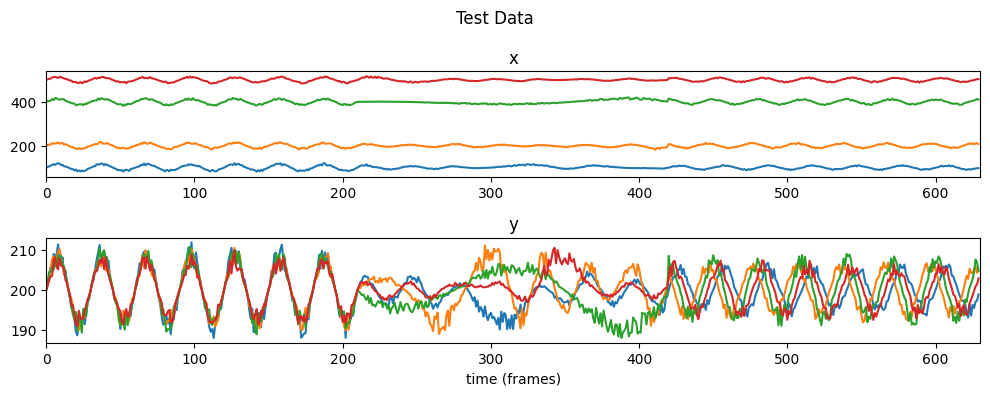

In [5]:
testdata_vars = init_testdatavars()
# testdata_vars['point_vars'][[0,2],...,5] = 0 # <=== no noise
test_data = testdata(testdata_vars)

n_axes = testdata_vars['n_axes']
n_points = testdata_vars['n_points']
total_duration = testdata_vars['total_duration']
ax_labels = ['x','y']
plt.figure(figsize=(10,4))
for i_ax in range(n_axes):
    plt.subplot(n_axes,1,i_ax+1)
    for i_p in range(n_points):
        plt.plot(test_data[i_p,i_ax,:])
    plt.title(ax_labels[i_ax])
    plt.xlim((0,total_duration))
plt.xlabel('time (frames)')
plt.suptitle('Test Data')
plt.tight_layout();